## Get the necessary files and packages

In [ ]:
%pip install chemfusekit

# Optional: download the example data from the repository (you could upload your own files)
!wget https://github.com/f-aguzzi/tesi/raw/main/tests/qepas.xlsx
!wget https://github.com/f-aguzzi/tesi/raw/main/tests/rt.xlsx

# Automatically inline the graphs
%matplotlib inline

## First case: fused vs non-fused data

In [ ]:
from chemfusekit.df import DFSettings, DF, Table
from chemfusekit.lr import LRSettings, LR, GraphMode

# Let's import a table of QEPAS data (needs SNV preprocessing)
table1 = Table(
    file_path='../tests/qepas.xlsx',
    sheet_name='Sheet1',
    class_column='Substance',
    preprocessing='snv'
)
df = DF(DFSettings(), [table1])
df.fuse()
data = df.fused_data

# Perform LR on the imported QEPAS data
lr_settings = LRSettings(output=GraphMode.GRAPHIC, test_split=True)
lr = LR(lr_settings, data)
lr.train()


The previous analysis (QEPAS-only) produced 4 misplaced samples, with a 97% overall accuracy.

Let's repeat it on GC data.

In [ ]:
from chemfusekit.__base import BaseDataModel

# Let's import a raw table of QEPAS data
data = BaseDataModel.load_from_file(
    import_path='../tests/rt.xlsx',
    sheet_name='Sheet1',
    class_column='Substance'
)

# Perform LR on the imported QEPAS data
lr_settings = LRSettings(output=GraphMode.GRAPHIC, test_split=True)
lr = LR(lr_settings, data)
lr.train()

The GC-only analysis produced a 24.5% accurate model, which is an incredibly low score. Now let's try a low-level data fusion analysis.

In [ ]:
from chemfusekit.df import DFSettings, DF, Table

# QEPAS table
table1 = Table(
    file_path='../tests/qepas.xlsx',
    sheet_name='Sheet1',
    class_column='Substance',
    preprocessing='snv'
)

# GC table
table2 = Table(
    file_path='../tests/rt.xlsx',
    sheet_name='Sheet1',
    class_column='Substance',
    preprocessing='none'
)

# Set up and perform data fusion
df = DF(DFSettings(), [table1, table2])
df.fuse()
data = df.fused_data

# Set up and perform LR
lr_settings = LRSettings(output=GraphMode.GRAPHIC, test_split=True)
lr = LR(lr_settings, data)
lr.train()

The precision score and the number of misrecognized samples is almost indistinguishable from the QEPAS-only analysis, already proving a point: without feature reduction, data from high-dimensionality sensors drowns out data from low-dimensionality sensors.

## Second phase: before vs after dimensionality reduction

In this phase of the case study, we will try two different strategies for dimensionality reduction of the incoming data:

1. perform low-level data fusion, and then apply a PLSDA reduction to the fused dataset
2. perform mid-level data fusion by appling PLSDA reduction to the QEPAS data before fusing it to the GC data

In [ ]:
from chemfusekit.plsda import PLSDASettings, PLSDA

# Perform low-level data fusion
table1 = Table(
    file_path='../tests/qepas.xlsx',
    sheet_name='Sheet1',
    class_column='Substance',
    preprocessing='snv'
)
table2 = Table(
    file_path='../tests/rt.xlsx',
    sheet_name='Sheet1',
    class_column='Substance',
    preprocessing='none'
)
df = DF(DFSettings(), [table1, table2])
df.fuse()
data = df.fused_data

# Reduce the dimensionality of the fused dataset
plsda = PLSDA(PLSDASettings(), data)
plsda.train()
data = plsda.rescaled_data
print(plsda.rescaled_data.x_train)

# REMOVE:
data.x_train.columns = ['Substance', '1', '2', '3', '4', '5']

# Set up and perform LR
lr_settings = LRSettings(output=GraphMode.GRAPHIC, test_split=True)
lr = LR(lr_settings, data)
lr.train()

The precision is 87% with 26 misplaced samples.

Now let's try mid-level data fusion.

In [ ]:
# Perform mid-level data fusion
table1 = Table(
    file_path='../tests/qepas.xlsx',
    sheet_name='Sheet1',
    class_column='Substance',
    preprocessing='snv',
    feature_selection='plsda'
)
table2 = Table(
    file_path='../tests/rt.xlsx',
    sheet_name='Sheet1',
    class_column='Substance',
    preprocessing='none'
)
df = DF(DFSettings(), [table1, table2])
df.fuse()
data = df.fused_data

# Set up and perform LR
lr_settings = LRSettings(output=GraphMode.GRAPHIC, test_split=True)
lr = LR(lr_settings, data)
lr.train()

In [ ]:
# QEPAS only, PLSDA

# Perform mid-level data fusion
table1 = Table(
    file_path='../tests/qepas.xlsx',
    sheet_name='Sheet1',
    class_column='Substance',
    preprocessing='snv',
    feature_selection='plsda'
)
df = DF(DFSettings(), [table1])
df.fuse()
data = df.fused_data

# Set up and perform LR
lr_settings = LRSettings(output=GraphMode.GRAPHIC, test_split=True)
lr = LR(lr_settings, data)
lr.train()

Along with what was observed by Borras et al. in their study, mid-level data fusion seems to work better than low-level data fusion.

Let's try the same using PCA instead of PLSDA for dimensionality reduction.

In [ ]:
from chemfusekit.pca import PCASettings, PCA

# Perform low-level data fusion
table1 = Table(
    file_path='../tests/qepas.xlsx',
    sheet_name='Sheet1',
    class_column='Substance',
    preprocessing='snv'
)
table2 = Table(
    file_path='../tests/rt.xlsx',
    sheet_name='Sheet1',
    class_column='Substance',
    preprocessing='none'
)
df = DF(DFSettings(), [table1, table2])
df.fuse()
data = df.fused_data

# Reduce the dimensionality of the fused dataset
pca = PCA(PCASettings(), data)
data = pca.rescaled_data

# Set up and perform LR
lr_settings = LRSettings(output=GraphMode.GRAPHIC, test_split=True)
lr = LR(lr_settings, data)
lr.train()

In [ ]:
# Perform mid-level data fusion
table1 = Table(
    file_path='../tests/qepas.xlsx',
    sheet_name='Sheet1',
    class_column='Substance',
    preprocessing='snv',
    feature_selection='pca'
)
table2 = Table(
    file_path='../tests/rt.xlsx',
    sheet_name='Sheet1',
    class_column='Substance',
    preprocessing='none'
)
df = DF(DFSettings(), [table1, table2])
df.fuse()
data = df.fused_data

# Set up and perform LR
lr_settings = LRSettings(output=GraphMode.GRAPHIC, test_split=True)
lr = LR(lr_settings, data)
lr.train()

## Conclusions

PCA seems to yield a higher precision than PLSDA when run with automatic settings, yet in both cases (PCA and PLSDA) the mid-level and low-level data fusion techniques seem to bring the same exact results in terms of correctly classified samples and scores.

## Last step (to solve a doubt): no data fusion vs data fusion

In [ ]:
# Perform mid-level data fusion
table1 = Table(
    file_path='../tests/qepas.xlsx',
    sheet_name='Sheet1',
    class_column='Substance',
    preprocessing='snv',
    feature_selection='pca'
)
df = DF(DFSettings(), [table1])
df.fuse()
data = df.fused_data

# Set up and perform LR
lr_settings = LRSettings(output=GraphMode.GRAPHIC, test_split=True)
lr = LR(lr_settings, data)
lr.train()

# With another dataset: let's see if the same happens



['DMMP' 'DMMP' 'DMMP' 'DMMP' 'DMMP' 'DMMP' 'DMMP' 'DMMP' 'DMMP' 'DMMP'
 'DMMP' 'DMMP' 'DMMP' 'DMMP' 'acetone' 'acetone' 'acetone' 'acetone'
 'acetone' 'acetone']


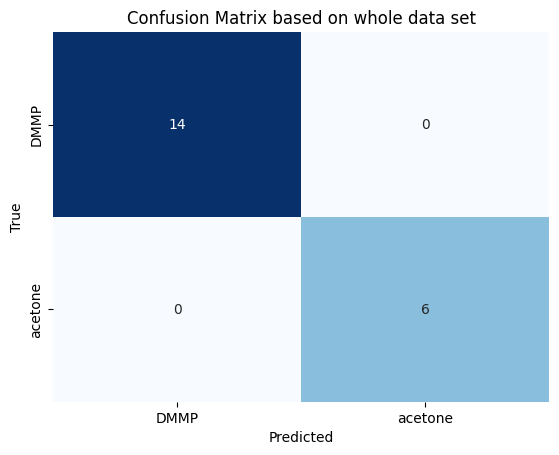

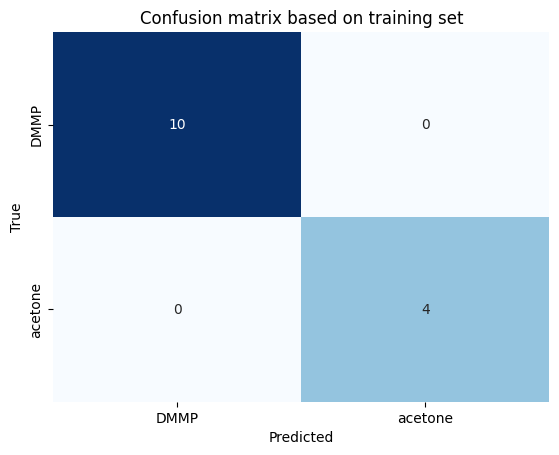

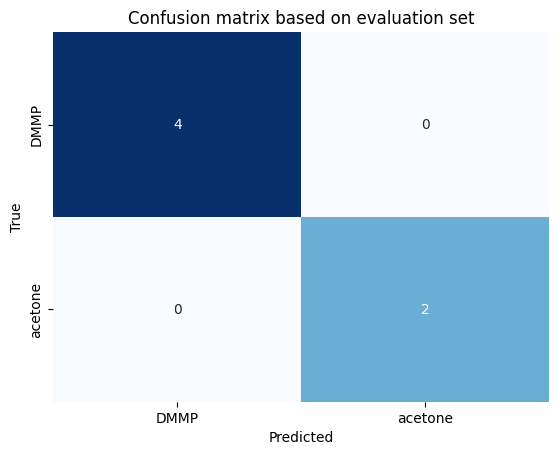

In [3]:
from chemfusekit.df import DFSettings, DF, Table, GraphMode
from chemfusekit.lr import LRSettings, LR
from chemfusekit.pca import PCASettings, PCA

# Set up the import settings for the first table (IMS spectral data)
table1 = Table(
    file_path='./IMS_GC_QEPAS.xlsx',
    sheet_name='IMS',
    preprocessing='snv',
    class_column='Class'
)

# Set up the import settings for the second table (GC chromatography data)
table2 = Table(
    file_path='./IMS_GC_QEPAS.xlsx',
    sheet_name='GC',
    preprocessing='none',
    class_column='Class'
)

# Set up the import settings for the third table (QEPAS spectral data)
table3 = Table(
    file_path='./IMS_GC_QEPAS.xlsx',
    sheet_name='QEPAS',
    preprocessing='snv',
    class_column='Class'
)

# Now, let's make an array of the three tables
# tables = [table1, table2, table3]
df = DF(DFSettings(), [table1, table2, table3])
df.fuse()
data = df.fused_data
print(data.y)

# Reduce the dimensionality of the fused dataset
pca = PCA(PCASettings(), data)
data = pca.rescaled_data

# Set up and perform LR
lr_settings = LRSettings(output=GraphMode.GRAPHIC, test_split=True)
lr = LR(lr_settings, data)
lr.train()

In [4]:
from chemfusekit.df import DFSettings, DF, Table

# Set up the import settings for the first table (IMS spectral data)
table1 = Table(
    file_path='IMS_GC_QEPAS.xlsx',
    sheet_name='IMS',
    preprocessing='snv',
    class_column='Class',
    index_column='Sample_id',
    feature_selection='pca'
)

# Set up the import settings for the second table (GC chromatography data)
table2 = Table(
    file_path='IMS_GC_QEPAS.xlsx',
    sheet_name='GC',
    preprocessing='none',
    class_column='Class',
    index_column='Sample_id'
)

# Set up the import settings for the third table (QEPAS spectral data)
table3 = Table(
    file_path='IMS_GC_QEPAS.xlsx',
    sheet_name='QEPAS',
    preprocessing='snv',
    class_column='Class',
    index_column='Sample_id',
    feature_selection='pca'
)

# Now, let's make an array of the three tables
df = DF(DFSettings(), [table1, table2, table3])
df.fuse()
data = df.fused_data


# Set up and perform LR
lr_settings = LRSettings(output=GraphMode.GRAPHIC, test_split=True)
lr = LR(lr_settings, data)
lr.train()

AttributeError: 'DataFrame' object has no attribute 'Substance'